# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression



In [1]:
version  = '15'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data="graupel"

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                   (cell: 2684736)
Dimensions without coordinates: cell
Data variables: (12/97)
    time                      (cell) float32 ...
    q_cloud                   (cell) float32 ...
    n_cloud                   (cell) float32 ...
    q_rain                    (cell) float32 ...
    n_rain                    (cell) float32 ...
    q_ice                     (cell) float32 ...
    ...                        ...
    frze_graupel_rain_mass    (cell) float32 ...
    frze_graupel_rain_rmass   (cell) float32 ...
    frze_graupel_rain_rvol    (cell) float32 ...
    frze_graupel_rain_liq     (cell) float32 ...
    rime_graupel_rain_num     (cell) float32 ...
    rime_graupel_rain_mass    (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     So  5 Jun 2022 13:37:07 CEST
    nfiles:   18051


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    q_s  = xr.open_dataset(fname).q_graupel.values
    n_s  = xr.open_dataset(fname).n_graupel.values
    r_s  = xr.open_dataset(fname).rime_graupel.values
    v_s  = xr.open_dataset(fname).rvol_graupel.values
    liq  = xr.open_dataset(fname).liq_graupel.values    
    q_r  = xr.open_dataset(fname).q_rain.values
    n_r  = xr.open_dataset(fname).n_rain.values    
    # process rates
    rime_mass = xr.open_dataset(fname).rime_graupel_rain_mass.values
    # some numerical lower bounds
    q_min = 1e-15
    n_min = 1e-15
    z_min = 1e-20
    p_min = 1e-20
    # use liquid water fraction
    liq = np.where(q_s>p_min,liq/q_s,np.nan)  
    liq = np.where(liq>0.0,liq,np.nan)  
    # transform everything in log space
    n_s = np.log(n_s, where=n_s>n_min, out=np.nan*n_s)
    q_s = np.log(q_s, where=q_s>q_min, out=np.nan*n_s)
    r_s = np.log(r_s, where=r_s>q_min, out=np.nan*n_s)
    v_s = np.log(v_s, where=v_s>q_min, out=np.nan*n_s)
    q_r = np.log(q_r, where=q_r>q_min, out=np.nan*n_s)
    n_r = np.log(n_r, where=n_r>q_min, out=np.nan*n_s)
    rime_mass  = np.log(rime_mass, where=rime_mass>p_min, out=np.nan*rime_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ q_s, n_s, r_s, v_s, liq, q_r, n_r, temp, rho, rime_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'q_s', 'n_s', 'r_s', 'v_s', 'liqfrac', 'q_r', 'n_r', 'temp', 'rho', 'rime_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

q_s            n_s            r_s            v_s  \
count  962387.000000  962387.000000  962387.000000  962387.000000   
mean       -7.311016       2.422121      -7.967730     -14.632462   
std         3.303840       4.116760       3.687473       3.729719   
min       -23.016495     -14.498609     -28.387684     -34.519760   
25%        -9.021292       0.577287     -10.012097     -16.709265   
50%        -6.282298       3.485876      -6.831165     -13.490316   
75%        -4.789321       5.202962      -5.104891     -11.698936   
max        -3.506558      10.567309      -3.508092      -8.966767   

            liqfrac            q_r            n_r           temp  \
count  9.623870e+05  962387.000000  962387.000000  962387.000000   
mean   3.492760e-01      -9.894917       4.350250     271.654602   
std    3.072337e-01       4.254982       3.531151       8.943827   
min    2.340053e-15     -34.399277     -14.498609     242.339996   
25%    7.673354e-02     -12.382893       2.449193     266.959991   
50%    2.587610e-01      -8.706117       5.069219     274.290009   
75%    6.044751e-01      -6.552041       6.819689     277.059998   
max    1.000000e+00      -3.507992      13.761435     297.190002   

                 rho      rime_mass  
count  962387.000000  962387.000000  
mean        1.061298     -16.551310  
std         0.150811       4.380571  
min         0.607000     -38.648762  
25%         0.972000     -19.205513  
50%         1.107000     -16.036516  
75%         1.177000     -13.368423  
max         1.285000      -6.536819

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

q_s       n_s        r_s        v_s   liqfrac        q_r       n_r  \
264 -11.622149  3.325468 -11.757280 -17.911457  0.092827 -14.541140  5.034091   
266 -11.634167  3.307326 -11.800421 -17.952616  0.120453 -11.744618  7.468228   
269 -11.655019  3.286535 -11.877502 -18.029856  0.167958 -10.707253  8.186409   
270 -11.652808  3.281851 -11.896722 -18.049738  0.185563 -10.537121  8.279367   
273 -11.659838  3.272417 -11.976549 -18.133173  0.242770 -10.165034  8.430327   

           temp    rho  rime_mass  
264  273.579987  1.098 -21.571970  
266  273.649994  1.099 -21.278175  
269  273.739990  1.101 -20.282928  
270  273.769989  1.101 -18.937073  
273  273.869995  1.103 -20.901592

In [11]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  673215.000000  673215.000000  673215.000000  673215.000000   
mean       -7.312028       2.425227      -7.968714     -14.633518   
std         3.303337       4.112422       3.687276       3.729576   
min       -23.016495     -14.498609     -28.387684     -34.519760   
25%        -9.023488       0.577287     -10.015180     -16.713355   
50%        -6.282780       3.487467      -6.831628     -13.490244   
75%        -4.789694       5.201861      -5.106194     -11.698750   
max        -3.506558      10.517429      -3.508092      -8.973136   

            liqfrac            q_r            n_r           temp  \
count  6.732150e+05  673215.000000  673215.000000  673215.000000   
mean   3.492810e-01      -9.893975       4.350985     271.648163   
std    3.072118e-01       4.254302       3.530815       8.941394   
min    2.340053e-15     -34.334286     -14.498609     242.339996   
25%    7.688779e-02     -12.377170       2.451436     266.950012   
50%    2.587050e-01      -8.705814       5.069722     274.290009   
75%    6.043310e-01      -6.553513       6.820142     277.059998   
max    9.999285e-01      -3.508259      13.761435     297.190002   

                 rho      rime_mass  
count  673215.000000  673215.000000  
mean        1.061211     -16.551737  
std         0.150871       4.381241  
min         0.607000     -38.648762  
25%         0.972000     -19.202407  
50%         1.107000     -16.035576  
75%         1.177000     -13.369198  
max         1.285000      -6.536819

In [12]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  144446.000000  144446.000000  144446.000000  144446.000000   
mean       -7.309937       2.410864      -7.968524     -14.632953   
std         3.304754       4.131070       3.687736       3.730022   
min       -22.943073     -14.498609     -27.687771     -34.508053   
25%        -9.010609       0.574631     -10.004546     -16.701644   
50%        -6.286131       3.479839      -6.828251     -13.487178   
75%        -4.789730       5.206147      -5.107904     -11.703641   
max        -3.506691      10.455215      -3.514724      -9.004709   

            liqfrac            q_r            n_r           temp  \
count  1.444460e+05  144446.000000  144446.000000  144446.000000   
mean   3.501617e-01      -9.881748       4.354668     271.678833   
std    3.073778e-01       4.254121       3.529555       8.944816   
min    2.185699e-13     -34.098202     -14.498609     243.410004   
25%    7.721085e-02     -12.380759       2.462427     266.989990   
50%    2.606864e-01      -8.698026       5.083762     274.299988   
75%    6.057608e-01      -6.534607       6.822611     277.089996   
max    9.999628e-01      -3.509094      13.758379     296.640015   

                 rho      rime_mass  
count  144446.000000  144446.000000  
mean        1.061630     -16.536839  
std         0.150481       4.381642  
min         0.608000     -38.514023  
25%         0.973000     -19.199592  
50%         1.107000     -16.027391  
75%         1.177000     -13.356577  
max         1.284000      -6.928088

In [13]:
dataset_val.describe()

q_s            n_s            r_s            v_s  \
count  144726.000000  144726.000000  144726.000000  144726.000000   
mean       -7.307402       2.418906      -7.962365     -14.627085   
std         3.305288       4.122624       3.688149       3.730108   
min       -22.979635     -14.498609     -27.760880     -34.256912   
25%        -9.023031       0.577343     -10.005581     -16.699501   
50%        -6.277175       3.483407      -6.833019     -13.492847   
75%        -4.786935       5.205201      -5.096283     -11.694627   
max        -3.506691      10.567309      -3.517181      -8.966767   

            liqfrac            q_r            n_r           temp  \
count  1.447260e+05  144726.000000  144726.000000  144726.000000   
mean   3.483689e-01      -9.912456       4.342412     271.659882   
std    3.071912e-01       4.258976       3.534314       8.954160   
min    3.475189e-14     -34.399277     -14.403416     242.679993   
25%    7.556523e-02     -12.411825       2.426417     267.000000   
50%    2.570920e-01      -8.716895       5.050625     274.290009   
75%    6.035189e-01      -6.562624       6.815050     277.059998   
max    1.000000e+00      -3.507992      13.475342     296.839996   

                 rho      rime_mass  
count  144726.000000  144726.000000  
mean        1.061370     -16.563749  
std         0.150859       4.376374  
min         0.607000     -38.453407  
25%         0.973000     -19.226110  
50%         1.107000     -16.051297  
75%         1.177000     -13.377146  
max         1.285000      -6.759525

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['q_s'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

q_s            n_s            r_s            v_s  \
count  671660.000000  671660.000000  671660.000000  671660.000000   
mean       -7.280040       2.459723      -7.933842     -14.598402   
std         3.239268       4.053670       3.618581       3.660823   
min       -19.999348     -14.498609     -27.083536     -33.679691   
25%        -8.993557       0.605463      -9.980628     -16.682129   
50%        -6.271708       3.496962      -6.822679     -13.481327   
75%        -4.786821       5.205599      -5.102385     -11.695320   
max        -3.506558      10.517429      -3.508092      -8.973136   

            liqfrac            q_r            n_r           temp  \
count  6.716600e+05  671660.000000  671660.000000  671660.000000   
mean   3.484072e-01      -9.903888       4.346599     271.632751   
std    3.068339e-01       4.253639       3.533420       8.944656   
min    2.340053e-15     -34.334286     -14.498609     242.339996   
25%    7.654140e-02     -12.386971       2.443043     266.920013   
50%    2.575184e-01      -8.718239       5.062152     274.279999   
75%    6.023927e-01      -6.564023       6.821197     277.040009   
max    9.999285e-01      -3.508259      13.761435     297.190002   

                 rho      rime_mass  
count  671660.000000  671660.000000  
mean        1.060889     -16.529396  
std         0.150877       4.360464  
min         0.607000     -38.648762  
25%         0.971000     -19.174577  
50%         1.107000     -16.023549  
75%         1.177000     -13.363211  
max         1.285000      -6.536819

In [17]:
dataset_test.describe()

q_s            n_s            r_s            v_s  \
count  144110.000000  144110.000000  144110.000000  144110.000000   
mean       -7.277506       2.445795      -7.933163     -14.597332   
std         3.239315       4.071431       3.617498       3.659648   
min       -19.993546     -14.498609     -25.141211     -31.708155   
25%        -8.980022       0.603564      -9.969943     -16.670867   
50%        -6.274252       3.489635      -6.818463     -13.478717   
75%        -4.786348       5.210196      -5.104191     -11.701021   
max        -3.506691      10.455215      -3.514724      -9.004709   

            liqfrac            q_r            n_r           temp  \
count  1.441100e+05  144110.000000  144110.000000  144110.000000   
mean   3.492827e-01      -9.891757       4.350220     271.663361   
std    3.069920e-01       4.253279       3.532197       8.948357   
min    2.185699e-13     -34.098202     -14.498609     243.410004   
25%    7.685659e-02     -12.391944       2.453609     266.970001   
50%    2.594473e-01      -8.709535       5.076704     274.290009   
75%    6.042874e-01      -6.544919       6.822949     277.079987   
max    9.999628e-01      -3.509094      13.758379     296.640015   

                 rho      rime_mass  
count  144110.000000  144110.000000  
mean        1.061299     -16.514154  
std         0.150480       4.360110  
min         0.608000     -38.514023  
25%         0.972000     -19.172623  
50%         1.107000     -16.014254  
75%         1.177000     -13.349190  
max         1.284000      -6.928088

### Pairplot

In [18]:
sns.pairplot(dataset_train[["rime_mass","q_s","n_s","r_s","v_s","liqfrac","q_r","n_r"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['liqfrac','rho','temp'], axis=1)
train_dataset2 = train_dataset2.drop(['rho','temp'], axis=1)
#train_dataset3 = train_dataset3.drop(['rho'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['liqfrac','rho','temp'], axis=1)
test_dataset2 = test_dataset2.drop(['rho','temp'], axis=1)
#test_dataset3 = test_dataset3.drop(['rho'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['liqfrac','rho','temp'], axis=1)
val_dataset2 = val_dataset2.drop(['rho','temp'], axis=1)
#val_dataset3 = val_dataset3.drop(['rho'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("rime_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
q_s  671660.0  -7.280040  3.239268 -19.999348  -8.993557  -6.271708   
n_s  671660.0   2.459723  4.053670 -14.498609   0.605463   3.496962   
r_s  671660.0  -7.933842  3.618581 -27.083536  -9.980628  -6.822679   
v_s  671660.0 -14.598402  3.660823 -33.679691 -16.682129 -13.481327   
q_r  671660.0  -9.903888  4.253639 -34.334286 -12.386971  -8.718239   
n_r  671660.0   4.346599  3.533420 -14.498609   2.443043   5.062152   

           75%        max  
q_s  -4.786821  -3.506558  
n_s   5.205599  10.517429  
r_s  -5.102385  -3.508092  
v_s -11.695320  -8.973136  
q_r  -6.564023  -3.508259  
n_r   6.821197  13.761435

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("rime_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count       mean       std           min        25%        50%  \
q_s      671660.0  -7.280040  3.239268 -1.999935e+01  -8.993557  -6.271708   
n_s      671660.0   2.459723  4.053670 -1.449861e+01   0.605463   3.496962   
r_s      671660.0  -7.933842  3.618581 -2.708354e+01  -9.980628  -6.822679   
v_s      671660.0 -14.598402  3.660823 -3.367969e+01 -16.682129 -13.481327   
liqfrac  671660.0   0.348407  0.306834  2.340053e-15   0.076541   0.257518   
q_r      671660.0  -9.903888  4.253639 -3.433429e+01 -12.386971  -8.718239   
n_r      671660.0   4.346599  3.533420 -1.449861e+01   2.443043   5.062152   

               75%        max  
q_s      -4.786821  -3.506558  
n_s       5.205599  10.517429  
r_s      -5.102385  -3.508092  
v_s     -11.695320  -8.973136  
liqfrac   0.602393   0.999929  
q_r      -6.564023  -3.508259  
n_r       6.821197  13.761435

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("rime_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean       std           min         25%         50%  \
q_s      671660.0   -7.280040  3.239268 -1.999935e+01   -8.993557   -6.271708   
n_s      671660.0    2.459723  4.053670 -1.449861e+01    0.605463    3.496962   
r_s      671660.0   -7.933842  3.618581 -2.708354e+01   -9.980628   -6.822679   
v_s      671660.0  -14.598402  3.660823 -3.367969e+01  -16.682129  -13.481327   
liqfrac  671660.0    0.348407  0.306834  2.340053e-15    0.076541    0.257518   
q_r      671660.0   -9.903888  4.253639 -3.433429e+01  -12.386971   -8.718239   
n_r      671660.0    4.346599  3.533420 -1.449861e+01    2.443043    5.062152   
temp     671660.0  271.632751  8.944656  2.423400e+02  266.920013  274.279999   
rho      671660.0    1.060889  0.150877  6.070000e-01    0.971000    1.107000   

                75%         max  
q_s       -4.786821   -3.506558  
n_s        5.205599   10.517429  
r_s       -5.102385   -3.508092  
v_s      -11.695320   -8.973136  
liqfrac    0.602393    0.999929  
q_r       -6.564023   -3.508259  
n_r        6.821197   13.761435  
temp     277.040009  297.190002  
rho        1.177000    1.285000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [28]:
# pop does not work for multiple columns, use copy instead

labels = [ 'rime_mass' ]

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [29]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [30]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [31]:
train_labels.describe()

rime_mass
count  671660.000000
mean      -16.529396
std         4.360464
min       -38.648762
25%       -19.174577
50%       -16.023549
75%       -13.363211
max        -6.536819

In [32]:
train_dataset1.describe()

q_s            n_s            r_s            v_s  \
count  671660.000000  671660.000000  671660.000000  671660.000000   
mean       -7.280040       2.459723      -7.933842     -14.598402   
std         3.239268       4.053670       3.618581       3.660823   
min       -19.999348     -14.498609     -27.083536     -33.679691   
25%        -8.993557       0.605463      -9.980628     -16.682129   
50%        -6.271708       3.496962      -6.822679     -13.481327   
75%        -4.786821       5.205599      -5.102385     -11.695320   
max        -3.506558      10.517429      -3.508092      -8.973136   

                 q_r            n_r  
count  671660.000000  671660.000000  
mean       -9.903888       4.346599  
std         4.253639       3.533420  
min       -34.334286     -14.498609  
25%       -12.386971       2.443043  
50%        -8.718239       5.062152  
75%        -6.564023       6.821197  
max        -3.508259      13.761435

In [33]:
train_dataset2.describe()

q_s            n_s            r_s            v_s  \
count  671660.000000  671660.000000  671660.000000  671660.000000   
mean       -7.280040       2.459723      -7.933842     -14.598402   
std         3.239268       4.053670       3.618581       3.660823   
min       -19.999348     -14.498609     -27.083536     -33.679691   
25%        -8.993557       0.605463      -9.980628     -16.682129   
50%        -6.271708       3.496962      -6.822679     -13.481327   
75%        -4.786821       5.205599      -5.102385     -11.695320   
max        -3.506558      10.517429      -3.508092      -8.973136   

            liqfrac            q_r            n_r  
count  6.716600e+05  671660.000000  671660.000000  
mean   3.484072e-01      -9.903888       4.346599  
std    3.068339e-01       4.253639       3.533420  
min    2.340053e-15     -34.334286     -14.498609  
25%    7.654140e-02     -12.386971       2.443043  
50%    2.575184e-01      -8.718239       5.062152  
75%    6.023927e-01      -6.564023       6.821197  
max    9.999285e-01      -3.508259      13.761435

In [34]:
train_dataset3.describe()

q_s            n_s            r_s            v_s  \
count  671660.000000  671660.000000  671660.000000  671660.000000   
mean       -7.280040       2.459723      -7.933842     -14.598402   
std         3.239268       4.053670       3.618581       3.660823   
min       -19.999348     -14.498609     -27.083536     -33.679691   
25%        -8.993557       0.605463      -9.980628     -16.682129   
50%        -6.271708       3.496962      -6.822679     -13.481327   
75%        -4.786821       5.205599      -5.102385     -11.695320   
max        -3.506558      10.517429      -3.508092      -8.973136   

            liqfrac            q_r            n_r           temp  \
count  6.716600e+05  671660.000000  671660.000000  671660.000000   
mean   3.484072e-01      -9.903888       4.346599     271.632751   
std    3.068339e-01       4.253639       3.533420       8.944656   
min    2.340053e-15     -34.334286     -14.498609     242.339996   
25%    7.654140e-02     -12.386971       2.443043     266.920013   
50%    2.575184e-01      -8.718239       5.062152     274.279999   
75%    6.023927e-01      -6.564023       6.821197     277.040009   
max    9.999285e-01      -3.508259      13.761435     297.190002   

                 rho  
count  671660.000000  
mean        1.060889  
std         0.150877  
min         0.607000  
25%         0.971000  
50%         1.107000  
75%         1.177000  
max         1.285000

### Normalize the features

In [35]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)

In [36]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
q_s  671660.0 -3.977083e-07  1.0 -3.926599 -0.528983  0.311284  0.769686   
n_s  671660.0  3.825847e-08  1.0 -4.183452 -0.457428  0.255876  0.677380   
r_s  671660.0  7.021088e-07  1.0 -5.292046 -0.565632  0.307072  0.782477   
v_s  671660.0 -1.874126e-07  1.0 -5.212294 -0.569196  0.305143  0.793013   
q_r  671660.0  4.004382e-09  1.0 -5.743412 -0.583755  0.278738  0.785178   
n_r  671660.0 -1.390520e-07  1.0 -5.333418 -0.538729  0.202510  0.700341   

          max  
q_s  1.164918  
n_s  1.987756  
r_s  1.223062  
v_s  1.536612  
q_r  1.503566  
n_r  2.664510

In [37]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
q_s      671660.0 -3.977083e-07  1.0 -3.926599 -0.528983  0.311284  0.769686   
n_s      671660.0  3.825847e-08  1.0 -4.183452 -0.457428  0.255876  0.677380   
r_s      671660.0  7.021088e-07  1.0 -5.292046 -0.565632  0.307072  0.782477   
v_s      671660.0 -1.874126e-07  1.0 -5.212294 -0.569196  0.305143  0.793013   
liqfrac  671660.0  1.457622e-09  1.0 -1.135491 -0.886036 -0.296215  0.827763   
q_r      671660.0  4.004382e-09  1.0 -5.743412 -0.583755  0.278738  0.785178   
n_r      671660.0 -1.390520e-07  1.0 -5.333418 -0.538729  0.202510  0.700341   

              max  
q_s      1.164918  
n_s      1.987756  
r_s      1.223062  
v_s      1.536612  
liqfrac  2.123368  
q_r      1.503566  
n_r      2.664510

In [38]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
q_s      671660.0 -3.977083e-07  1.0 -3.926599 -0.528983  0.311284  0.769686   
n_s      671660.0  3.825847e-08  1.0 -4.183452 -0.457428  0.255876  0.677380   
r_s      671660.0  7.021088e-07  1.0 -5.292046 -0.565632  0.307072  0.782477   
v_s      671660.0 -1.874126e-07  1.0 -5.212294 -0.569196  0.305143  0.793013   
liqfrac  671660.0  1.457622e-09  1.0 -1.135491 -0.886036 -0.296215  0.827763   
q_r      671660.0  4.004382e-09  1.0 -5.743412 -0.583755  0.278738  0.785178   
n_r      671660.0 -1.390520e-07  1.0 -5.333418 -0.538729  0.202510  0.700341   
temp     671660.0 -6.355150e-06  1.0 -3.274889 -0.526877  0.295959  0.604524   
rho      671660.0 -2.791332e-07  1.0 -3.008335 -0.595773  0.305623  0.769577   

              max  
q_s      1.164918  
n_s      1.987756  
r_s      1.223062  
v_s      1.536612  
liqfrac  2.123368  
q_r      1.503566  
n_r      2.664510  
temp     2.857265  
rho      1.485392

### Normalize the labels

In [39]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%        50%  \
rime_mass  671660.0 -16.529396  4.360464 -38.648762 -19.174577 -16.023549   

                 75%       max  
rime_mass -13.363211 -6.536819

In [40]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [41]:

def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be used with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [42]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(6,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                112       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 673
Trainable params: 673
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [44]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.8514812 ],
       [-0.8470331 ],
       [-0.8452631 ],
       [-0.8449445 ],
       [-0.84403026],
       [-0.84375405],
       [-0.84314287],
       [-0.842705  ],
       [-0.8423699 ],
       [-0.8418601 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [45]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [46]:
activ = "ReLU"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0749,  mae:0.1447,  mse:0.0749,  val_loss:0.0707,  val_mae:0.1488,  val_mse:0.0707,  
........................................

In [48]:
histories['ReLU'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.16])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [49]:
model2 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0723,  mae:0.1405,  mse:0.0723,  val_loss:0.0696,  val_mae:0.1418,  val_mse:0.0696,  
.............................................

In [50]:
histories['liq-ReLU'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.16])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

In [51]:
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0740,  mae:0.1432,  mse:0.0740,  val_loss:0.0709,  val_mae:0.1526,  val_mse:0.0709,  
........................................

Text(0, 0.5, 'MAE')

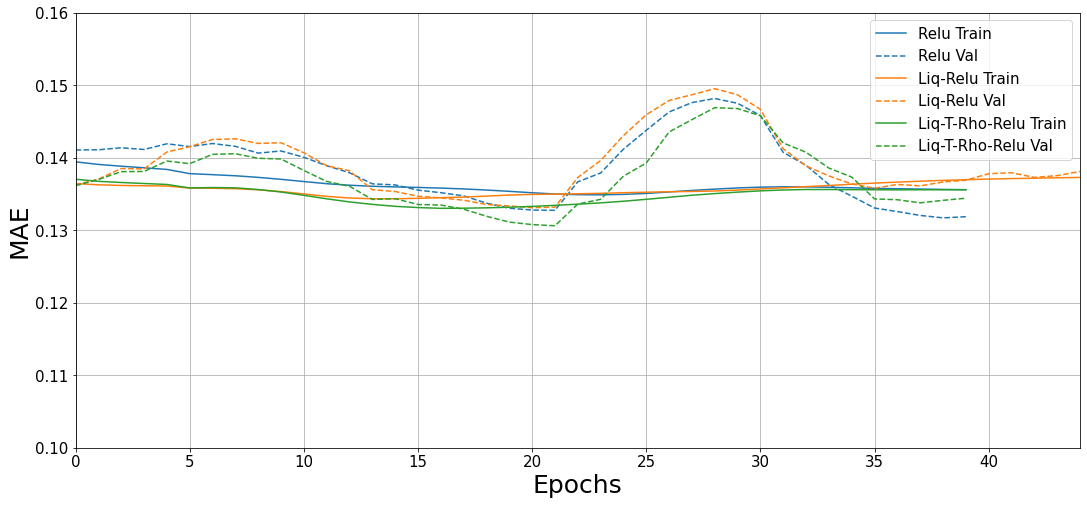

In [54]:
histories['liq-T-rho-ReLU'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.16])
plt.ylabel('MAE')

In [55]:
activ = "ReLU_Adam"
model4 = build_model(len(normed_train_data2.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data2, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data2,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0767,  mae:0.1475,  mse:0.0767,  val_loss:0.0701,  val_mae:0.1381,  val_mse:0.0701,  
....................................................

Text(0, 0.5, 'MAE')

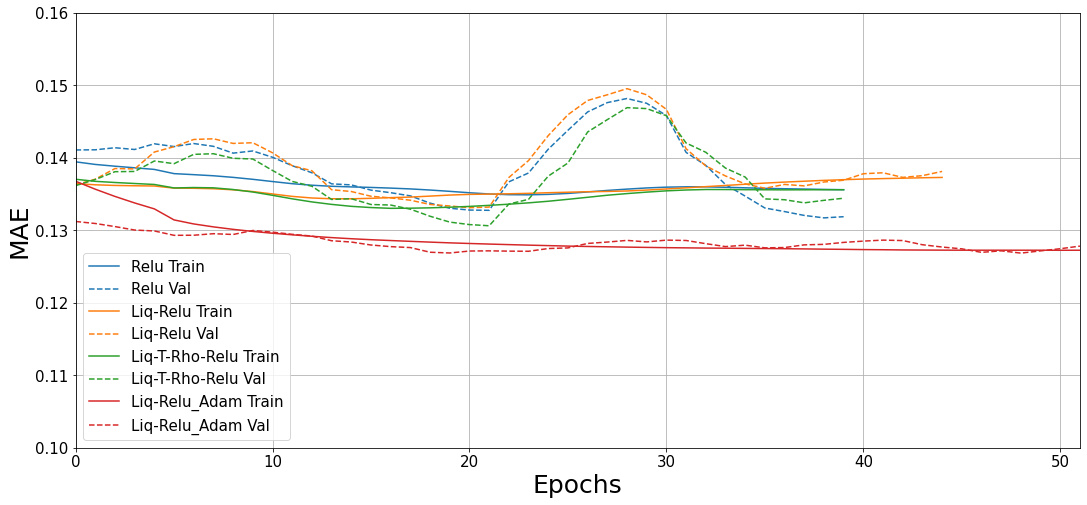

In [56]:
histories['liq-ReLU_Adam'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.1, 0.16])
plt.ylabel('MAE')

In [57]:
nsize=16
model5 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history5 = model5.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0734,  mae:0.1425,  mse:0.0734,  val_loss:0.0691,  val_mae:0.1366,  val_mse:0.0691,  
....................................................................................................
Epoch: 100, loss:0.0624,  mae:0.1247,  mse:0.0624,  val_loss:0.0623,  val_mae:0.1238,  val_mse:0.0623,  
.........

In [59]:
histories['liq-T-rho-ReLU_Adam'] = early_history5

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.12, 0.16])
plt.ylabel('MAE')

Text(0, 0.5, 'MAE')

Text(0, 0.5, 'MSE')

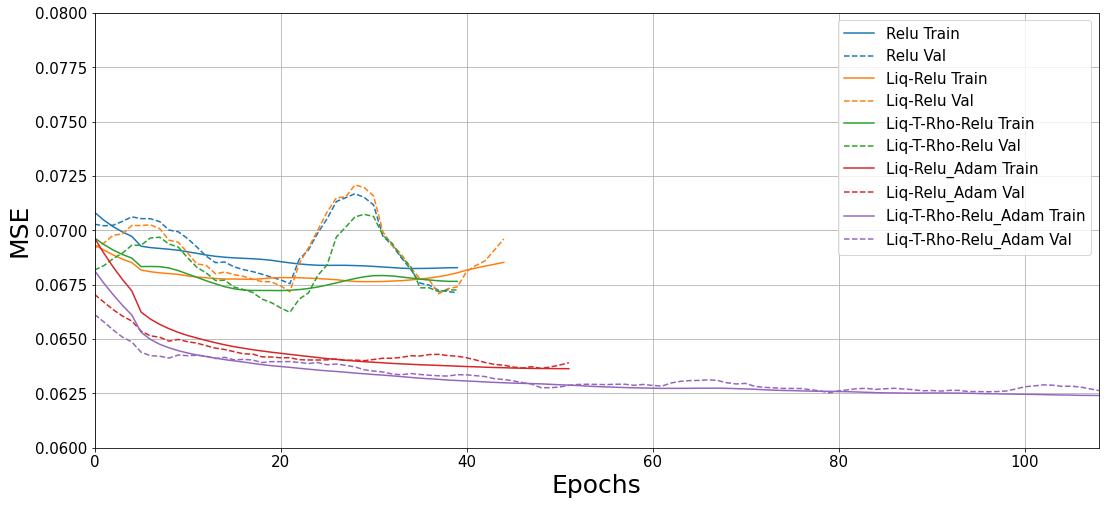

In [61]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.06, 0.08])
plt.ylabel('MSE')

In [62]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

144110/144110 - 3s - loss: 0.0664 - mae: 0.1304 - mse: 0.0664
Testing set for model 1, Mean Abs Error:    0.13040


In [63]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

144110/144110 - 3s - loss: 0.0658 - mae: 0.1306 - mse: 0.0658
Testing set for model 2, Mean Abs Error:              0.13059


In [64]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

144110/144110 - 3s - loss: 0.0650 - mae: 0.1283 - mse: 0.0650
Testing set for model 3, Mean Abs Error:              0.12830


In [65]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data2, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

144110/144110 - 3s - loss: 0.0634 - mae: 0.1260 - mse: 0.0634
Testing set for model 4, Mean Abs Error:              0.12596


In [66]:
loss5, mae5, mse5 = model5.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 5, Mean Abs Error: {:20.5f}".format(mae5))

144110/144110 - 3s - loss: 0.0624 - mae: 0.1236 - mse: 0.0624
Testing set for model 5, Mean Abs Error:              0.12360


In [67]:
mae = [ mae1, mae2, mae3, mae4, mae5 ]
mae

[0.1304033, 0.13059281, 0.12830235, 0.12596492, 0.1235958]

In [68]:
mse = [ mse1, mse2, mse3, mse4, mse5 ]
mse

[0.06638234, 0.065783404, 0.06504898, 0.0633523, 0.062363066]

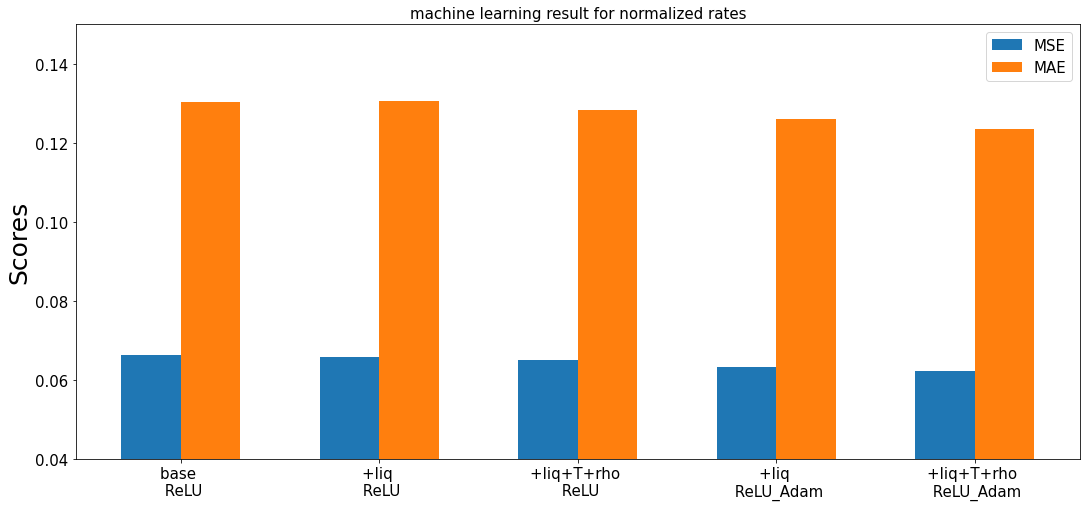

In [69]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = [
 'base \n ReLU',
 '+liq \n ReLU',
 '+liq+T+rho \n ReLU',
 '+liq \n ReLU_Adam',
 '+liq+T+rho \n ReLU_Adam' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized rates')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.04,0.15)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [70]:
test_true_mass = np.exp(test_labels.pop('rime_mass'))

In [71]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [72]:
labels = [ "rime_mass" ]

p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=labels)

In [73]:
p1.describe()

rime_mass
count  144110.000000
mean        0.005089
std         0.966980
min        -4.191216
25%        -0.637625
50%         0.095523
75%         0.728385
max         1.926377

In [74]:
train_labels_stats

count       mean       std        min        25%        50%  \
rime_mass  671660.0 -16.529396  4.360464 -38.648762 -19.174577 -16.023549   

                 75%       max  
rime_mass -13.363211 -6.536819

In [75]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [76]:
test_predict1.describe()

rime_mass
count  1.441100e+05
mean   6.654824e-06
std    2.269718e-05
min    7.662333e-16
25%    4.110440e-09
50%    1.005239e-07
75%    1.587584e-06
max    2.947158e-04

In [77]:
np.exp(test_dataset1.head())

q_s        n_s       r_s           v_s       q_r          n_r
271  0.000009  26.624998  0.000007  1.419000e-08  0.000030  4199.701172
275  0.000009  26.125000  0.000006  1.264900e-08  0.000047  4794.901367
293  0.000007  16.062002  0.000002  4.398701e-09  0.000193  4624.899414
296  0.000006  12.000000  0.000002  3.007301e-09  0.000258  4600.401855
420  0.000002   3.718800  0.000001  1.801701e-09  0.000034  3356.699219

In [78]:
test_predict1.head()

rime_mass
0  1.443350e-09
1  2.199342e-09
2  5.411951e-09
3  5.594813e-09
4  2.572008e-10

In [79]:
test_dataset2.head()

q_s       n_s        r_s        v_s   liqfrac        q_r       n_r
271 -11.650442  3.281851 -11.916902 -18.070728  0.203736 -10.402879  8.342769
275 -11.656715  3.262893 -12.027508 -18.185688  0.282575  -9.968837  8.475308
293 -11.849140  2.776456 -13.013509 -19.241957  0.675844  -8.551319  8.439210
296 -12.018681  2.484907 -13.371915 -19.622223  0.732012  -8.261002  8.433899
420 -13.392271  1.313401 -13.689936 -20.134535  0.224114 -10.285949  8.118713

In [80]:
test_predict1_mass = test_predict1['rime_mass']

In [81]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data2), columns=labels)

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_mass = test_predict2['rime_mass']


In [82]:

p3 = pd.DataFrame(data=model4.predict(normed_test_data2), columns=labels)

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_mass = test_predict3['rime_mass']


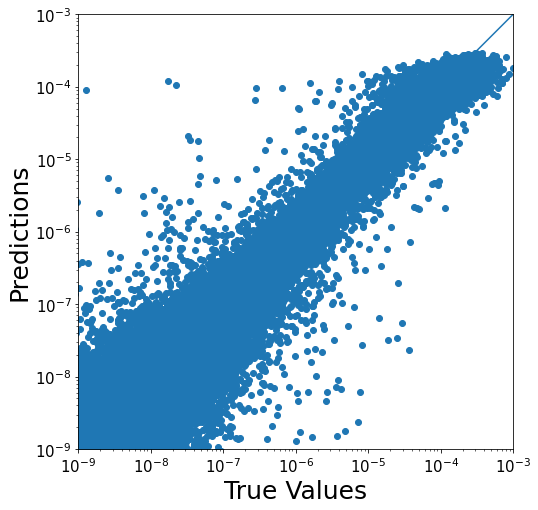

In [83]:
amin, amax = 1e-9, 1e-3

a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict1_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

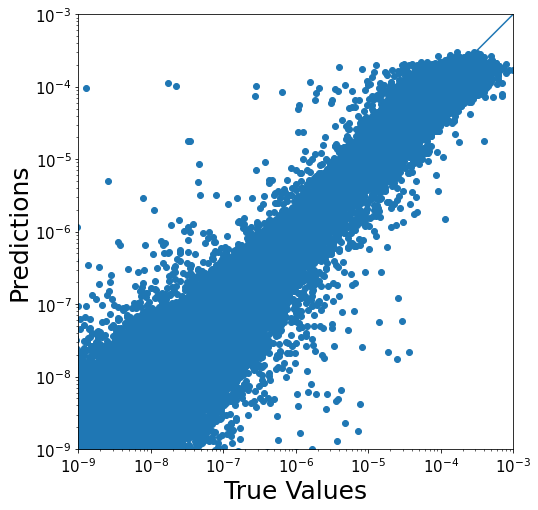

In [84]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict2_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

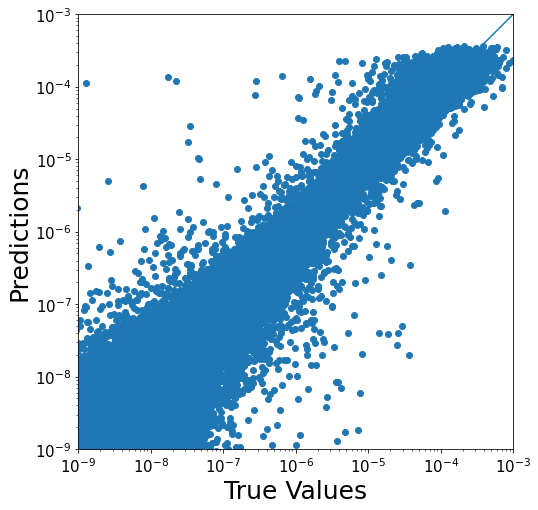

In [85]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_mass, test_predict3_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [86]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [87]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [88]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, q_rain, n_rain'
labels   = 'rime_graupel_rain_mass'
filename = 'saved_model_v2/rime_graupel_rain_model1_'+version+'.nc'
logtransform = np.array([True, True, True, True, True, True], dtype=bool)

In [89]:
train_stats1

count       mean       std        min        25%        50%  \
q_s  671660.0  -7.280040  3.239268 -19.999348  -8.993557  -6.271708   
n_s  671660.0   2.459723  4.053670 -14.498609   0.605463   3.496962   
r_s  671660.0  -7.933842  3.618581 -27.083536  -9.980628  -6.822679   
v_s  671660.0 -14.598402  3.660823 -33.679691 -16.682129 -13.481327   
q_r  671660.0  -9.903888  4.253639 -34.334286 -12.386971  -8.718239   
n_r  671660.0   4.346599  3.533420 -14.498609   2.443043   5.062152   

           75%        max  
q_s  -4.786821  -3.506558  
n_s   5.205599  10.517429  
r_s  -5.102385  -3.508092  
v_s -11.695320  -8.973136  
q_r  -6.564023  -3.508259  
n_r   6.821197  13.761435

In [90]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain'
logtransform = np.array([True, True, True, True, False, True, True], dtype=bool)

filename = 'saved_model_v2/rime_graupel_rain_model2_'+version+'.nc'
save2netcdf(model2,features,labels,train_stats2,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_graupel_rain_model4_'+version+'.nc'
save2netcdf(model4,features,labels,train_stats2,train_labels_stats,logtransform,filename)



Saving model to saved_model_v2/rime_graupel_rain_model2_15.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain
  Labels:     rime_graupel_rain_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/rime_graupel_rain_model4_15.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain
  Labels:     rime_graupel_rain_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (7, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activ

In [91]:
train_stats2

count       mean       std           min        25%        50%  \
q_s      671660.0  -7.280040  3.239268 -1.999935e+01  -8.993557  -6.271708   
n_s      671660.0   2.459723  4.053670 -1.449861e+01   0.605463   3.496962   
r_s      671660.0  -7.933842  3.618581 -2.708354e+01  -9.980628  -6.822679   
v_s      671660.0 -14.598402  3.660823 -3.367969e+01 -16.682129 -13.481327   
liqfrac  671660.0   0.348407  0.306834  2.340053e-15   0.076541   0.257518   
q_r      671660.0  -9.903888  4.253639 -3.433429e+01 -12.386971  -8.718239   
n_r      671660.0   4.346599  3.533420 -1.449861e+01   2.443043   5.062152   

               75%        max  
q_s      -4.786821  -3.506558  
n_s       5.205599  10.517429  
r_s      -5.102385  -3.508092  
v_s     -11.695320  -8.973136  
liqfrac   0.602393   0.999929  
q_r      -6.564023  -3.508259  
n_r       6.821197  13.761435

In [92]:
features = 'q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain, T, rho'
filename = 'saved_model_v2/rime_graupel_rain_model3_'+version+'.nc'
logtransform = np.array([True, True, True, True, False, True, True, False, False], dtype=bool)
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,filename)

filename = 'saved_model_v2/rime_graupel_rain_model5_'+version+'.nc'
save2netcdf(model5,features,labels,train_stats3,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/rime_graupel_rain_model3_15.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain, T, rho
  Labels:     rime_graupel_rain_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/rime_graupel_rain_model5_15.nc
  Features:   q_graupel, n_graupel, rmass_graupel, rvol_graupel, liqfrac, q_rain, n_rain, T, rho
  Labels:     rime_graupel_rain_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (9, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>,

In [93]:
train_stats3

count        mean       std           min         25%         50%  \
q_s      671660.0   -7.280040  3.239268 -1.999935e+01   -8.993557   -6.271708   
n_s      671660.0    2.459723  4.053670 -1.449861e+01    0.605463    3.496962   
r_s      671660.0   -7.933842  3.618581 -2.708354e+01   -9.980628   -6.822679   
v_s      671660.0  -14.598402  3.660823 -3.367969e+01  -16.682129  -13.481327   
liqfrac  671660.0    0.348407  0.306834  2.340053e-15    0.076541    0.257518   
q_r      671660.0   -9.903888  4.253639 -3.433429e+01  -12.386971   -8.718239   
n_r      671660.0    4.346599  3.533420 -1.449861e+01    2.443043    5.062152   
temp     671660.0  271.632751  8.944656  2.423400e+02  266.920013  274.279999   
rho      671660.0    1.060889  0.150877  6.070000e-01    0.971000    1.107000   

                75%         max  
q_s       -4.786821   -3.506558  
n_s        5.205599   10.517429  
r_s       -5.102385   -3.508092  
v_s      -11.695320   -8.973136  
liqfrac    0.602393    0.999929  
q_r       -6.564023   -3.508259  
n_r        6.821197   13.761435  
temp     277.040009  297.190002  
rho        1.177000    1.285000